In [92]:
import pandas as pd
import math
from shapely.geometry import Point, LineString, Polygon
from pyproj import Proj, transform
from matplotlib import pyplot as plt

In [2]:
bike_df_orig = pd.read_excel('data/Final_Bike_Collision_Database.xlsx')


In [3]:
bike_df_orig.columns

Index(['ID', 'YEAR', 'DATE', 'DAY_WEEK', 'TIME', 'TYPE', 'SOURCE', 'XFINAL',
       'Xkm', 'YFINAL', 'Ykm', 'Address', 'Main', 'RoadType', 'ISINTERSEC',
       'TRACT', 'CouncilDIS', 'Councillor', 'PlanningDi', 'OIF1', 'OIF2',
       'OIF3', 'OIF4', 'BLFinal', 'CS', 'LIGHTING', 'Indoor', 'Light',
       'LightEng', 'WEATHER', 'PrecipCond', 'AtmosCondi', 'DayNight', 'Tmax',
       'Tmin', 'Tavg', 'Temprange', 'SunriseTim', 'SunsetTime', 'SnowFall',
       'PrecipTota', 'Fault', 'Doored', 'HelmetDocu', 'TaxiFinal',
       'hitrunfina', 'AlcoholFin', 'INJURED', 'TRANSPORTE', 'TREATED',
       'GENDER', 'ETHNICITY', 'AGE', 'Narrative'],
      dtype='object')

In [4]:
bike_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 54 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ID          1808 non-null   object        
 1   YEAR        1797 non-null   float64       
 2   DATE        1797 non-null   datetime64[ns]
 3   DAY_WEEK    1795 non-null   object        
 4   TIME        1797 non-null   object        
 5   TYPE        1795 non-null   object        
 6   SOURCE      1699 non-null   object        
 7   XFINAL      1731 non-null   float64       
 8   Xkm         1730 non-null   float64       
 9   YFINAL      1731 non-null   float64       
 10  Ykm         1731 non-null   float64       
 11  Address     1730 non-null   object        
 12  Main        1731 non-null   float64       
 13  RoadType    1726 non-null   object        
 14  ISINTERSEC  1807 non-null   float64       
 15  TRACT       1731 non-null   float64       
 16  CouncilDIS  1731 non-nul

In [42]:
#Clean up begins
#drop rows with missing locations, since location is the most important part of this exploration
bike_df = pd.DataFrame(bike_df_orig[(bike_df_orig.Xkm > 0) & (bike_df_orig.Ykm > 0)])

In [6]:
column_list = list(bike_df.columns)

# remove columns where it doesn't make sense to look at the list of unique values
vals_to_remove = ['ID', 'DATE', 'TIME', 'XFINAL', 'Xkm', 'YFINAL', 'Ykm', 'TRACT', 'SunriseTim', 'SunsetTime',
                 'Narrative']
for val in vals_to_remove:
    column_list.remove(val)

for col in column_list:
    print(col)
    print(bike_df[col].unique())

YEAR
[2009. 2010. 2011. 2012.   nan]
DAY_WEEK
['Friday' 'Sunday' 'Thursday' 'Monday' 'Saturday' 'Wednesday' 'Tuesday'
 nan]
TYPE
['BVA' 'BVP' 'CO' 'BR' 'BVB' nan]
SOURCE
['E911' nan 'ON-SITE' 'WALK-IN' 'CALL SCREENING' 'PHONE-IN']
Address
['1001 Commonwealth Ave' '50 Kenilworth St' '584 Saratoga St' ...
 '540 Washington St' '562 Dorchester Ave' '886 Huntington Ave']
Main
[0. 1.]
RoadType
['Exe' 'Res' 'Com' 'Emp' 'Ind' nan]
ISINTERSEC
[1. 0.]
CouncilDIS
[8. 7. 1. 2. 5. 6. 4. 9. 3. 0.]
Councillor
['Councillor Ross' 'Councillor Jackson' 'Councillor LaMattina'
 'Councillor Linehan' 'Councillor Consalvo' "Councillor O'Malley"
 'Councillor Yancey' 'Councillor Ciommo' 'Councillor Baker' nan]
PlanningDi
['Allston/Brighton' 'Roxbury' 'East Boston' 'Central' 'Roslindale'
 'Back Bay/Beacon Hill' 'Fenway/Kenmore' 'Jamaica Plain' 'West Roxbury'
 'South End' 'Mattapan' 'North Dorchester' 'Hyde Park' 'Charlestown'
 'South Dorchester' 'South Boston' nan]
OIF1
[ 7.  3.  6. 10. 14.  0.  1.  2.  4. 11.  

In [7]:
#I want to add (a) column(s) to the dataframe to express an area where the accident occured
#According to the DOT the max width of a road surface is 84 m, so let's make squares that 
#are 100m sq around the accident location

#First I need to figure out if any of the accidents are within 50m of one another
#If so, they will be considered to have happened in the same place

#formula to calculate distance between two points
def calcDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return dist

#the first way I determined to do this involved nested for loops. Very slow. 
#A sort, and narrowing in on it seemed better

bike_df = bike_df.sort_values(by='Xkm').reset_index()
prev_Xkm = 0
prev_Ykm = 0
for index, row in bike_df.iterrows():
    print(index)
    if (prev_Xkm != 0):
        if ((row['Xkm'] - prev_Xkm) < 100): #if the x values are within 100m of each other
            dist = calcDistance(row['Xkm'], row['Ykm'], prev_Xkm, prev_Ykm)
            if (dist < 100): #test if the points are within 100m
                print(row['ID'] + ' is within ' + str(dist) + ' of prev')
    prev_Xkm = row['Xkm']
    prev_Ykm = row['Ykm']
            


0
1
2
3
4
5
6
7
8
B1282 is within 66.67165848561774 of prev
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
B2583 is within 0.0 of prev
28
29
30
31
32
33
34
35
36
37
38
39
40
B2104 is within 0.00010870604532507423 of prev
41
B2297 is within 5.174182944148677 of prev
42
B1508 is within 47.44247697126114 of prev
43
44
45
46
47
48
49
50
51
52
53
54
B1668 is within 19.764237200822507 of prev
55
B1705 is within 41.985859183185745 of prev
56
57
58
B2784 is within 24.694489971919737 of prev
59
60
61
62
63
B1891 is within 7.816118056136657 of prev
64
65
66
67
B1395 is within 0.0 of prev
68
B1768 is within 12.773198506323556 of prev
69
B1792 is within 95.01976650638943 of prev
70
B2098 is within 0.00023975404319836712 of prev
71
72
73
74
B1385 is within 0.0 of prev
75
B2423 is within 0.00021949483486465206 of prev
76
77
B1390 is within 9.085210876986558 of prev
78
79
80
B2165 is within 0.00021874177031758435 of prev
81
82
83
84
85
B1878 is within 0.0 of prev
86
B1510 is within 0.0 of pr

569
570
B2493 is within 5.727125282400506e-05 of prev
571
572
573
B2259 is within 0.0002106015223874523 of prev
574
575
576
577
578
579
580
581
582
B2252 is within 20.6811791743425 of prev
583
584
585
586
587
588
589
590
B2213 is within 0.0 of prev
591
592
593
594
595
596
597
598
599
600
B2326 is within 0.00022329359695466797 of prev
601
602
603
B1303 is within 0.0 of prev
604
B1338 is within 0.0 of prev
605
606
607
B2053 is within 9.24445464796438e-05 of prev
608
609
610
611
612
613
B2560 is within 0.00022489103354121032 of prev
614
B1822 is within 8.743340176128564 of prev
615
B2339 is within 0.00013097328239205263 of prev
616
B2254 is within 0.0 of prev
617
618
619
B2660 is within 0.00022022948363204078 of prev
620
B2801 is within 0.0 of prev
621
622
B1085 is within 0.0 of prev
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
B1933 is within 0.0 of prev
638
639
640
641
642
B2066 is within 9.525757009000485e-05 of prev
643
B1975 is within 0.0 of prev
644
B2438 is within 7.

B2716 is within 0.00023776030316453625 of prev
1045
B2635 is within 0.0 of prev
1046
1047
1048
1049
1050
B1544 is within 0.0 of prev
1051
1052
1053
1054
1055
1056
1057
1058
1059
B1640 is within 0.0 of prev
1060
1061
B2408 is within 0.0003068061732823208 of prev
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
B1778 is within 0.0 of prev
1077
B1372 is within 0.0 of prev
1078
B1958 is within 0.0001842606563005795 of prev
1079
1080
1081
B1872 is within 38.95350030381823 of prev
1082
1083
B1503 is within 0.0 of prev
1084
1085
1086
1087
1088
1089
1090
B1310 is within 0.0 of prev
1091
1092
B1098 is within 0.0 of prev
1093
B2531 is within 0.0002271497568028486 of prev
1094
B2609 is within 0.0 of prev
1095
1096
B1567 is within 73.86859926455395 of prev
1097
1098
B1907 is within 0.00010324727289159723 of prev
1099
B1506 is within 4.743183581511094 of prev
1100
1101
1102
1103
1104
B2528 is within 0.0 of prev
1105
1106
1107
1108
1109
1110
B1011 is within 0.0 of prev
1111

In [96]:
#This just determines that a lot of bike accidents are close to one another
#What I really need is to get them organized by clusters

#I'm going to build a brand new dataframe organized by clusters instead of individual accidents
#Every accident must have been within 50m of every other accident in the cluster

#Create list of points and lines and ids
#bike_df = bike_df.sort_values(by='Xkm').reset_index()
acc_clusters = []
prev_Xkm = 0
prev_Ykm = 0
prev_id = ''
points = []
accident_ids = []
prev_close = False
for index, row in bike_df.iterrows():
    points.append(Point(row['Xkm'], row['Ykm']))
    accident_ids.append(row['ID'])
    if (index != 0):
        if ((row['Xkm'] - prev_Xkm) < 50): #if the x values are within 50m of each other
            dist = calcDistance(row['Xkm'], row['Ykm'], prev_Xkm, prev_Ykm)
            if (dist < 50): #test if the points are within 50m
                print(str(row['Xkm']) + ',' + str(row['Ykm']) + ' to ' + str(prev_Xkm) + ',' + str(prev_Ykm) + 
                      ' is ' + str(dist))
                prev_close = True
            else:
                prev_close = False
        else:
            prev_close = False
    if not prev_close:
        acc_clusters.append({'shape': points, 'accident_ids': accident_ids})
        points = []
        accident_ids = []   
    prev_Xkm = row['Xkm']
    prev_Ykm = row['Ykm']

print(len(acc_clusters))
acc_clusters

227966.508364,900288.716769 to 227966.508364,900288.716769 is 0.0
228363.545723,899900.427 to 228363.545672,899900.427096 is 0.00010870604532507423
228366.049295,899895.898833 to 228363.545723,899900.427 is 5.174182944148677
228413.484257,899896.743227 to 228366.049295,899895.898833 is 47.44247697126114
228631.600994,898608.079262 to 228618.923498,898623.241919 is 19.764237200822507
228654.864489,898573.12755 to 228631.600994,898608.079262 is 41.985859183185745
228679.611422,900182.735174 to 228673.113639,900158.910887 is 24.694489971919737
228765.087473,898440.671747 to 228762.508974,898448.0503 is 7.816118056136657
228807.806283,900465.395866 to 228807.806283,900465.395866 is 0.0
228808.426211,900478.154012 to 228807.806283,900465.395866 is 12.773198506323556
228852.721965,900562.217143 to 228852.721894,900562.217372 is 0.00023975404319836712
228903.890591,898737.430222 to 228903.890591,898737.430222 is 0.0
228903.890738,898737.430059 to 228903.890591,898737.430222 is 0.0002194948348

231678.912377,893960.21656 to 231677.630798,893921.065914 is 39.17161634328588
231737.577724,895157.431882 to 231737.577724,895157.431882 is 0.0
231752.604155,895116.401471 to 231737.577724,895157.431882 is 43.69540313829902
231754.914956,900136.477046 to 231754.914956,900136.477046 is 0.0
231754.914956,900136.477046 to 231754.914956,900136.477046 is 0.0
231754.915111,900136.476908 to 231754.914956,900136.477046 is 0.0002075307346733806
231773.282658,895690.475166 to 231771.562012,895682.532081 is 8.127313330569867
231795.012601,894672.288054 to 231795.012601,894672.288054 is 0.0
231811.722876,896081.923133 to 231811.722876,896081.923133 is 0.0
231811.723013,896081.922984 to 231811.722876,896081.923133 is 0.0002024105348679202
231811.723013,896081.922984 to 231811.723013,896081.922984 is 0.0
231814.588344,896177.461727 to 231814.588157,896177.461893 is 0.00025005005966154153
231816.543258,895927.548804 to 231815.608579,895951.980973 is 24.4500410404433
231816.543258,895927.548804 to 23

234197.988612,897680.41289 to 234197.988503,897680.412936 is 0.00011830890513855087
234200.405824,897684.522351 to 234197.988612,897680.41289 is 4.767660176974412
234264.48487,899932.274232 to 234264.48487,899932.274232 is 0.0
234272.395854,899154.770387 to 234272.395854,899154.770387 is 0.0
234272.395854,899154.770387 to 234272.395854,899154.770387 is 0.0
234272.395854,899154.770387 to 234272.395854,899154.770387 is 0.0
234337.391644,898838.516771 to 234337.391644,898838.516771 is 0.0
234358.568582,897877.802341 to 234358.568582,897877.802341 is 0.0
234361.046699,897876.703709 to 234358.568582,897877.802341 is 2.7107298162851388
234399.979527,899876.198534 to 234399.979527,899876.198534 is 0.0
234401.439253,895516.517412 to 234401.439253,895516.517412 is 0.0
234402.944668,895501.658414 to 234401.439253,895516.517412 is 14.935062634199898
234459.32008,899517.796861 to 234459.320078,899517.796698 is 0.0001630122302605616
234459.32008,899517.796861 to 234459.32008,899517.796861 is 0.0
23

236195.803092,894170.389389 to 236195.802959,894170.389266 is 0.00018115738936867021
236195.803092,894170.389389 to 236195.803092,894170.389389 is 0.0
236195.803207,894170.389256 to 236195.803092,894170.389389 is 0.00017582375059754218
236195.803207,894170.389256 to 236195.803207,894170.389256 is 0.0
236195.803207,894170.389256 to 236195.803207,894170.389256 is 0.0
236300.335628,894652.521536 to 236295.571608,894651.864993 is 4.809047231120074
236343.708206,900809.126406 to 236343.708206,900809.126406 is 0.0
236345.865725,894984.584332 to 236345.148972,894950.91718 is 33.67478075139831
236361.027777,900487.090122 to 236355.4108,900487.22993 is 5.618716659112403
236377.101008,895149.909707 to 236372.96965,895153.031689 is 5.178309621108563
236377.101066,895149.909895 to 236377.101008,895149.909707 is 0.000196743522325445
236377.101145,895149.909697 to 236377.101066,895149.909895 is 0.0002131783202127184
236377.101145,895149.909697 to 236377.101145,895149.909697 is 0.0
236377.101145,8951

[{'shape': [<shapely.geometry.point.Point at 0x249e01b7dc8>],
  'accident_ids': ['B2078']},
 {'shape': [<shapely.geometry.point.Point at 0x249e42ec5c8>],
  'accident_ids': ['B1431']},
 {'shape': [<shapely.geometry.point.Point at 0x249e42c5fc8>],
  'accident_ids': ['B2649']},
 {'shape': [<shapely.geometry.point.Point at 0x249e423dd48>],
  'accident_ids': ['B2321']},
 {'shape': [<shapely.geometry.point.Point at 0x249e01b7d88>],
  'accident_ids': ['B2144']},
 {'shape': [<shapely.geometry.point.Point at 0x249e424fd88>],
  'accident_ids': ['B2774']},
 {'shape': [<shapely.geometry.point.Point at 0x249e3d79f88>],
  'accident_ids': ['B1578']},
 {'shape': [<shapely.geometry.point.Point at 0x249e4196e48>],
  'accident_ids': ['B1999']},
 {'shape': [<shapely.geometry.point.Point at 0x249e42ecb48>],
  'accident_ids': ['B1282']},
 {'shape': [<shapely.geometry.point.Point at 0x249e423d9c8>],
  'accident_ids': ['B2308']},
 {'shape': [<shapely.geometry.point.Point at 0x249e42a32c8>],
  'accident_ids': 

In [98]:
# make lists of length one into points, lists of length greater than one into Line strings
for counter, item in enumerate(acc_clusters):
    if (len(item['shape']) > 1):
        acc_clusters[counter]['shape'] = LineString(item['shape'])
    else:
        acc_clusters[counter]['shape'] = item['shape'][0]



In [99]:
#add a 50m buffer around the shapes
for counter, item in enumerate(acc_clusters):
    acc_clusters[counter]['buffer'] = item['shape'].buffer(50)



LINESTRING (228631.600994 898608.079262, 228654.864489 898573.12755, 228665.868376 892231.830995)


Text(0.5, 1.0, 'Polygon')

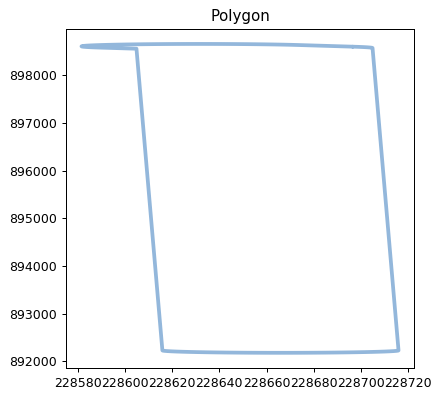

In [100]:
x,y = acc_clusters[50]['buffer'].exterior.xy
print(acc_clusters[50]['shape'])
fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)
ax.plot(x, y, color='#6699cc', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)
ax.set_title('Polygon')

In [74]:
#This just determines that a lot of bike accidents are close to one another
#What I really need is to get them organized by clusters

#I'm going to build a brand new dataframe organized by clusters instead of individual accidents
#Every accident must have been within 50m of every other accident in the cluster
#Each cluster will have an accident score, which is the number of accidents
#Each cluster will have points determining its perimeter, which will be 50m outside of the accidents
#Each cluster will have the following attributes:
    # XTop - 50m away from top Xkm
    # XBottom - 50m away from bottom Xkm
    # Ytop - 50m away from top Ykm
    # YBottom - 50m away from bottom Ykm
    # accidents, a list of tuples of (ID, Xkm, Ykm) for all accidents in the cluster

def isWithin(x, y, XTop, XBottom, YTop, YBottom):
    result = False
    if (x < XTop and x > XBottom and y < YTop and y > YBottom):
        result = True
    return result
    
acc_clusters = []
for index, row in bike_df.head(100).iterrows():
    acc_id, Xkm, Ykm = row['ID'], row['Xkm'], row['Ykm']
    added = False
    for cluster in acc_clusters:
        if isWithin(Xkm, Ykm, cluster['XTop'], cluster['XBottom'], cluster['YTop'], cluster['YBottom']):
            for acc in cluster['accidents']:
                if (calcDistance(Xkm, Ykm, acc[1], acc[2]) < 50):
                    if (Xkm + 50 > cluster['XTop']):
                        cluster['XTop'] = Xkm + 50
                    elif (Xkm - 50 < cluster['XBottom']):
                        cluster['XBottom'] = Xkm - 50
                    if (Ykm + 50 > cluster['YTop']):
                        cluster['YTop'] = Ykm + 50
                    elif (Ykm - 50 < cluster['YBottom']):
                        cluster['YBottom'] = Ykm - 50
                    cluster['accidents'].append((acc_id, Xkm, Ykm))
                    added = True
    if not added:
        cluster = {'XTop': Xkm + 50, 
                   'XBottom': Xkm - 50,
                  'YTop': Ykm + 50,
                  'YBottom': Ykm - 50,
                  'accidents': [(acc_id, Xkm, Ykm)]}
        acc_clusters.append(cluster)
acc_clusters

KeyboardInterrupt: 

In [6]:
bike_df[['Address', 'Xkm', 'Ykm']].head()

,Address,Xkm,Ykm
0,1001 Commonwealth Ave,231203.176793,900199.040998
1,280 Brighton Ave,NaN,900400.976894
2,50 Kenilworth St,233984.572264,897655.138169
3,584 Saratoga St,239308.085183,903574.276748
4,222 Harrison Ave,236029.648350,899772.501906


In [7]:
bike_df['Xkm'].max()

241169.656466

In [8]:
bike_df['Xkm'].min()

226872.564379

In [9]:
bike_df['Ykm'].max()

904055.441186

In [10]:
bike_df['Ykm'].min()

887256.463784

In [16]:
inProj = Proj('epsg:26986')
outProj = Proj('epsg:4326')
xmax,ymax = bike_df['Xkm'].max(),bike_df['Ykm'].max()
xmax2,ymax2 = transform(inProj,outProj,xmax,ymax)
print ('Upper Right: ')
print (xmax2,ymax2)

xmin,ymin = bike_df['Xkm'].min(),bike_df['Ykm'].min()
xmin2,ymin2 = transform(inProj,outProj,xmin,ymin)

print('Bottom Right:')
print(xmin2, ymax2)

print('Top Right: ')
print(xmax2, ymin2)

print ('Bottom Left: ')
print (xmin2,ymin2)

Upper Right: 
42.385920811282396 -71.00003640589748
Bottom Right:
42.23530626734878 -71.00003640589748
Top Right: 
42.385920811282396 -71.17443656586595
Bottom Left: 
42.23530626734878 -71.17443656586595


In [70]:
bike_df[['XFINAL', 'Xkm', 'YFINAL', 'Ykm']]

,XFINAL,Xkm,YFINAL,Ykm
0,758540.606275,231203.176793,2.953409e+06,900199.040998
1,754177.666510,NaN,2.954071e+06,900400.976894
2,767665.919501,233984.572264,2.945063e+06,897655.138169
3,785131.513067,239308.085183,2.964483e+06,903574.276748
4,774375.486713,236029.648350,2.952010e+06,899772.501906
...,...,...,...,...
1803,761171.822976,232005.171643,2.946305e+06,898033.855044
1804,NaN,NaN,NaN,NaN
1805,NaN,NaN,NaN,NaN
1806,NaN,NaN,NaN,NaN


In [4]:
car_df = pd.read_csv('data/US_Accidents_Dec19.csv')
car_df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [55]:
car_acc_df = pd.read_csv('data/2019_Crashes_.csv')


In [52]:
for col in car_acc_df.columns:
    print(col)

OBJECTID
CRASH_NUMB
CITY_TOWN_NAME
CRASH_DATE
CRASH_HOUR
CRASH_TIME_2
CRASH_STATUS
CRASH_SEVERITY_DESCR
MAX_INJR_SVRTY_CL
NUMB_VEHC
NUMB_NONFATAL_INJR
NUMB_FATAL_INJR
POLC_AGNCY_TYPE_DESCR
MANR_COLL_DESCR
VEHC_MNVR_ACTN_CL
VEHC_TRVL_DIRC_CL
VEHC_SEQ_EVENTS_CL
AMBNT_LIGHT_DESCR
WEATH_COND_DESCR
ROAD_SURF_COND_DESCR
FIRST_HRMF_EVENT_DESCR
MOST_HRMFL_EVT_CL
DRVR_CNTRB_CIRC_CL
VEHC_CONFIG_CL
STREET_NUMB
RDWY
DIST_DIRC_FROM_INT
NEAR_INT_RDWY
MM_RTE
DIST_DIRC_MILEMARKER
MILEMARKER
EXIT_RTE
DIST_DIRC_EXIT
EXIT_NUMB
DIST_DIRC_LANDMARK
LANDMARK
RDWY_JNCT_TYPE_DESCR
TRAF_CNTRL_DEVC_TYPE_DESCR
TRAFY_DESCR_DESCR
JURISDICTN
FIRST_HRMF_EVENT_LOC_DESCR
NON_MTRST_TYPE_CL
NON_MTRST_ACTN_CL
NON_MTRST_LOC_CL
IS_GEOCODED
GEOCODING_METHOD_NAME
X
Y
LAT
LON
RMV_DOC_IDS
CRASH_RPT_IDS
YEAR
AGE_DRVR_YNGST
AGE_DRVR_OLDEST
AGE_NONMTRST_YNGST
AGE_NONMTRST_OLDEST
DRVR_DISTRACTED_CL
DISTRICT_NUM
RPA_ABBR
VEHC_EMER_USE_CL
VEHC_TOWED_FROM_SCENE_CL
CNTY_NAME
FMCSA_RPTBL_CL
FMCSA_RPTBL
HIT_RUN_DESCR
LCLTY_NAME
ROAD_CNTR

In [9]:
small_df = car_acc_df[['CITY_TOWN_NAME', 'STREET_NUMB', 'DIST_DIRC_FROM_INT', 'NEAR_INT_RDWY', 'MM_RTE', 'X', 'Y', 'LAT', 'LON']]
small_df.head()

,CITY_TOWN_NAME,STREET_NUMB,DIST_DIRC_FROM_INT,NEAR_INT_RDWY,MM_RTE,X,Y,LAT,LON
0,ATTLEBORO,787,NaN,NaN,NaN,215161.511507,854356.129054,41.939413,-71.317171
1,SALEM,NaN,NaN,NaN,NaN,250114.124768,919085.062401,42.520699,-70.890113
2,SALEM,NaN,NaN,NaN,NaN,250148.187616,919544.562433,42.524834,-70.889659
3,EVERETT,NaN,NaN,NaN,NaN,237161.046996,905476.187380,42.398912,-71.048625
4,HAVERHILL,NaN,NaN,NaN,NaN,237365.471188,946305.656602,42.766455,-71.043487


In [21]:
small2_df = car_acc_df[['HIT_RUN_DESCR', 'ROAD_CNTRB_DESCR']]
small2_df.head()

,HIT_RUN_DESCR,ROAD_CNTRB_DESCR
0,"Yes, hit and run",None
1,No hit and run,"Road surface condition (wet, icy, snow, slush,..."
2,No hit and run,None
3,No hit and run,None
4,No hit and run,None


In [44]:
data_row = list(car_acc_df.loc[[0]].to_numpy()[0])
data_cols = list(car_acc_df.columns)
list_of_tuples = list(zip(data_cols, data_row))
#list_of_tuples[0]
list_of_tuples

[('OBJECTID', 2504847),
 ('CRASH_NUMB', 4643564),
 ('CITY_TOWN_NAME', 'ATTLEBORO'),
 ('CRASH_DATE', '2019-01-01T06:00:00.000Z'),
 ('CRASH_HOUR', '01:00AM to 01:59AM'),
 ('CRASH_TIME_2', '01:00 AM'),
 ('CRASH_STATUS', 'Open'),
 ('CRASH_SEVERITY_DESCR', 'Property damage only (none injured)'),
 ('MAX_INJR_SVRTY_CL', 'No injury'),
 ('NUMB_VEHC', 1),
 ('NUMB_NONFATAL_INJR', 0),
 ('NUMB_FATAL_INJR', 0),
 ('POLC_AGNCY_TYPE_DESCR', 'Local police'),
 ('MANR_COLL_DESCR', 'Single vehicle crash'),
 ('VEHC_MNVR_ACTN_CL', 'V1: Travelling straight ahead'),
 ('VEHC_TRVL_DIRC_CL', 'V1: E'),
 ('VEHC_SEQ_EVENTS_CL',
  ' V1:(Collision with embankment),(Collision with fence)'),
 ('AMBNT_LIGHT_DESCR', 'Dark - lighted roadway'),
 ('WEATH_COND_DESCR', 'Rain'),
 ('ROAD_SURF_COND_DESCR', 'Wet'),
 ('FIRST_HRMF_EVENT_DESCR', 'Collision with embankment'),
 ('MOST_HRMFL_EVT_CL', 'V1:(Collision with embankment)'),
 ('DRVR_CNTRB_CIRC_CL', nan),
 ('VEHC_CONFIG_CL', 'V1:(Passenger car)'),
 ('STREET_NUMB', '787'),
 ('RD

In [58]:
#list of columns with descriptive data in them that might contain bike or bicycle
desc_col_list = ['CRASH_SEVERITY_DESCR', 'MANR_COLL_DESCR', 'VEHC_SEQ_EVENTS_CL', 'MOST_HRMFL_EVT_CL', 'VEHC_CONFIG_CL']
fixed_df = car_acc_df.fillna('')


,OBJECTID,CRASH_NUMB,CITY_TOWN_NAME,CRASH_DATE,CRASH_HOUR,CRASH_TIME_2,CRASH_STATUS,CRASH_SEVERITY_DESCR,MAX_INJR_SVRTY_CL,NUMB_VEHC,...,TERRAIN,URBAN_LOC_TYPE,AADT_DERIV,STATN_NUM,OP_DIR_SL,SHLDR_UL_T,SHLDR_UL_W,T_EXC_TYPE,T_EXC_TIME,F_F_CLASS


In [68]:
def contains_bike(df, colname):
    bikes_filter = []
    if(type(df[colname]) == 'str'):
        bikes_filter = df[colname].str.upper().str.contains('BIKE') | df[colname].str.upper().str.contains('BICYCLE')
    return bikes_filter
#bike = fixed_df[fixed_df['CRASH_SEVERITY_DESCR'].str.contains('bike')]

for col in fixed_df.columns:
    if(contains_bike(fixed_df, col)):
        print(col)


In [45]:
vehicle_configs = car_acc_df.groupby('VEHC_CONFIG_CL').count()
vehicle_configs

,OBJECTID,CRASH_NUMB,CITY_TOWN_NAME,CRASH_DATE,CRASH_HOUR,CRASH_TIME_2,CRASH_STATUS,CRASH_SEVERITY_DESCR,MAX_INJR_SVRTY_CL,NUMB_VEHC,...,TERRAIN,URBAN_LOC_TYPE,AADT_DERIV,STATN_NUM,OP_DIR_SL,SHLDR_UL_T,SHLDR_UL_W,T_EXC_TYPE,T_EXC_TIME,F_F_CLASS
VEHC_CONFIG_CL,,,,,,,,,,,,,,,,,,,,,
"V10:(Passenger car) / V1:(Passenger car) / V2:(Passenger car) / V3:(Passenger car) / V4:(Passenger car) / V5:(Passenger car) / V6:(Passenger car) / V7:(Passenger car) / V8:(Passenger car) / V9:(Light truck(van, mini-van, pickup, sport utility)) / V11:(Passenger car)",1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,1
"V11:(Passenger car) / V10:(Passenger car) / V9:(Passenger car) / V8:(Passenger car) / V7:(Passenger car) / V4:(Light truck(van, mini-van, pickup, sport utility)) / V5:(Passenger car) / V3:(Passenger car) / V2:(Light truck(van, mini-van, pickup, sport utility)) / V1:(Other e.g. farm equipment) / V12:(Passenger car) / V6:(Passenger car) / V13:(Passenger car)",1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,1,0,0,1
V1:(All Terrain Vehicle (ATV)),11,11,11,11,11,11,11,11,11,11,...,11,2,3,0,4,9,9,0,0,11
V1:(All Terrain Vehicle (ATV)) / V2:(All Terrain Vehicle (ATV)),1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,1,0,0,1
"V1:(All Terrain Vehicle (ATV)) / V2:(Light truck(van, mini-van, pickup, sport utility))",2,2,2,2,2,2,2,2,2,2,...,2,0,1,1,1,2,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"V8:(Passenger car) / V1:(Light truck(van, mini-van, pickup, sport utility)) / V2:(Passenger car) / V3:(Passenger car) / V4:(Passenger car) / V5:(Light truck(van, mini-van, pickup, sport utility)) / V6:(Light truck(van, mini-van, pickup, sport utility)) / V7:(Passenger car) / V9:(Passenger car)",1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,1,0,0,1
V8:(Passenger car) / V1:(Passenger car) / V2:(Passenger car) / V3:(Passenger car) / V4:(Passenger car) / V5:(Passenger car) / V6:(Passenger car) / V7:(Passenger car) / V9:(Passenger car),1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,0,0,1
V8:(Passenger car) / V2:(Passenger car) / V3:(Passenger car) / V4:(Passenger car) / V5:(Passenger car) / V6:(Passenger car) / V7:(Passenger car) / V1:(Truck/trailer),1,1,1,1,1,1,1,1,1,1,...,1,0,1,0,1,1,1,0,0,1
